In [1]:
import argparse
import os
import time
from threading import Thread

import importlib
import pandas as pd
import numpy as np
from pandas.io import gbq
from google.cloud import bigquery
from google.cloud import storage
import pydata_google_auth

import cv2
from PIL import Image
from scipy.spatial import distance as dist

import skimage.io as skio
from matplotlib import pyplot as plt

In [2]:
from imutils import perspective
import imutils

# Items to Address

* Lifestyle image is default
* 2 products in image
* Non-white background color

* If product is horizontal, which side should determine orientation angle?
*flip product?
*scale

In [3]:
credentials = pydata_google_auth.get_user_credentials(
                        ['https://www.googleapis.com/auth/bigquery'],)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-3425ks60hkk80fssi9vpohv88g6q1iqd.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=EUutDdP6BY0Ap6ynoRZ7kXwyzDFNgu&prompt=consent&access_type=offline


Enter the authorization code:  4/1AX4XfWhacXgfrOE6GEwoTJzbetvBFNZvKyfEd2jSj_sJAc3r9Ta1gs4xVhk


In [5]:
project_id = 'analytics-online-data-sci-thd'

# Get Images

In [6]:
query = '''select distinct OMS_SKU,description,pd.image_path top_image_path,Class_Name, Class_Nbr, Dept_Name,Dept_Nbr,
discontinued_sku,wta.Taxonomy,
alt_images.attribute_name,alt_images.image_path alt_image_path
from analytics-online-thd.Master.Product_Dim_Master_wPS  pd inner join
analytics-online-thd.Master.PR1_Website_Taxonomy wta
on trim(OMS_SKU) = cast(wta.oms_id as string)
inner join
(select
omsid,
displayname as attribute_name,
attributevalue,
concat("https://idm.homedepot.com/assets/image/",  substr(attributevalue, 0, 2), "/", attributevalue, ".jpg") as image_path
from
analytics-online-data-sci-thd.recommendation.ItemAttributes a join
analytics-online-data-sci-thd.recommendation.Attributes b
on a.attributeid = b.attribute_id
where
displayname like '%Image%' and
displayname not in ('Image Enhancement Available', 'Maximum Image Resolution', 'PLP Secondary Image GUID', 'THD Proprietary Brand Product Image', 'Image Sensor Type')
and displayname = 'Product Image') 
 alt_images
 on  trim(pd.OMS_SKU) = alt_images.omsid
WHERE trim(Source_System) = 'STEP'
and wta.taxonomy in (select taxonomy from `hd-personalization-prod.personalization.common_CATGPENREL_taxonomy` where taxonomy like 'Tools>Hand Tools>Hammers%')
and trim(discontinued_sku) = 'N'
and trim(online_status) = 'TRUE'
and channel_status like '%DOTCOM_CERTIFIED%'
and channel_status not like '%DISCONTINUED%' and hide_sku_on_web = 0
order by pd.OMS_SKU
'''

In [7]:
data = gbq.read_gbq(query=query, dialect ='standard', project_id=project_id)

In [8]:
sample = data.head(5)

# Remove Background
- Covert to gray, and threshold
- Morph-op to remove noise
- Find max contour area
- Crop & save

In [9]:
# util

def read_image(path):
    '''
    :param path:
    :return:
    '''
    img_skio = skio.imread(path)
    im_pil = Image.fromarray(img_skio)
    im = np.asarray(im_pil)
    return im, im_pil
    
# def read_image(path):
#     return cv2.imread(path)

In [10]:
ex = sample.iloc[0].top_image_path

In [11]:
img, img_pil = read_image(ex)

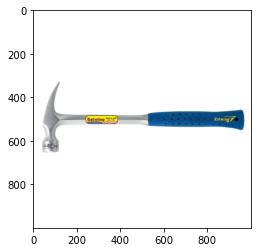

In [12]:
plt.imshow(img);

In [13]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [14]:
blurred = cv2.GaussianBlur(gray, (7,7), 0)

In [16]:
#simple thresholding
# (T, threshInv) = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY_INV)

# thresholding - OTSU
# (T, threshInv) = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

# print(f'OTSUs threshold value: {T}')


#thresholding - adaptive
threshInv = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 4)
#plt.imshow(threshInv, cmap='gray',vmin = 0, vmax = 255)

In [ ]:
#Show mask
# masked = cv2.bitwise_and(img, img, mask=threshInv)
# plt.imshow(masked, cmap='gray',vmin = 0, vmax = 255)

In [17]:
## (2) Morph-op to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
morphed = cv2.morphologyEx(threshInv, cv2.MORPH_CLOSE, kernel) #dialation, then erosion

In [18]:
## (3) Find the max-area contour
cnts, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = sorted(cnts, key=cv2.contourArea)[-1]

In [19]:
## (4) Crop and save it
x,y,w,h = cv2.boundingRect(cnt)
dst = img[y:y+h, x:x+w]

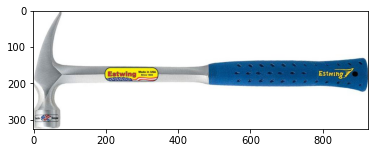

In [20]:
plt.imshow(dst)

# Measure Orientation of Object

In [21]:
# find lines
M = cv2.moments(cnt)

In [22]:
center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

In [23]:
theta = 0.5*np.arctan2(2*M["mu11"],M["mu20"]-M["mu02"])

In [24]:
endx = 600 * np.cos(theta) + center[0] # linelength 600
endy = 600 * np.sin(theta) + center[1]

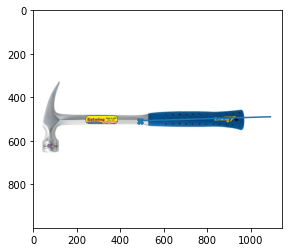

In [25]:
plt.imshow(img, cmap='gray')
plt.scatter(center[0], center[1], marker="X")
plt.plot([center[0], endx], [center[1], endy])
plt.show()

# Find Top of Hammer

* Split the image into 4 quadrants
* Count non zero pixels in each quadrant
* Find closet angle or orientation 

In [26]:
image = morphed

In [27]:
height = image.shape[0]
width = image.shape[1]

In [28]:
width_cutoff = width // 2
height_cutoff = height // 2

In [29]:
q1 = image[:height_cutoff, width_cutoff:]
q2 = image[:height_cutoff, :width_cutoff]
q3 = image[height_cutoff:height, :width_cutoff]
q4 = image[height_cutoff:height, width_cutoff:]

In [30]:
counts = []

for q in [q1, q2, q3, q4]:
    counts.append(cv2.countNonZero(q))

In [31]:
max_index = counts.index(max(counts))

In [32]:
min_index = counts.index(min(counts))

In [33]:
max_quad = max_index + 1

In [34]:
second_max= -1

for i in range(len(counts)):

    if counts[min_index] < counts[i]:
        if counts[max_index] > counts[i]:
            if counts[i] > second_max:
                second_max = counts[i]

In [35]:
second_max_quad = counts.index(second_max) + 1

In [36]:
gen_orientation = sorted([max_quad, second_max_quad])

In [37]:
d = {1:90, 2:180, 3:370, 4: 0}

In [38]:
desired_angle = d[gen_orientation[0]]

In [39]:
if theta < 0:
    a1 = theta + 360

if a1 > 180:
    a2 = a1 - 180
else:
    a2 = a1 + 180

In [40]:
if abs(desired_angle - a1) > abs(desired_angle - a2):
    item_angle = round(a2)
else:
    item_angle = round(a1)

# Rotation

In [41]:
#center of image
(h,w) = dst.shape[:2]
(cX, cY) = (w//2, h//2)

In [42]:
#M = cv2.getRotationMatrix2D((cX, cY), -90, 1.0)
# rotated = cv2.warpAffine(dst, M, (w,h))
# rotated = imutils.rotate(dst, -90)

rotation = item_angle - 90

rotated = imutils.rotate_bound(dst, rotation)

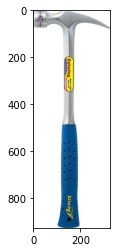

In [43]:
plt.imshow(rotated)

# Flip

In [44]:
gray_r = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
blurred_r = cv2.GaussianBlur(gray_r, (7,7), 0)
threshInv_r = cv2.adaptiveThreshold(blurred_r, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 4)

In [45]:
width_r = threshInv_r.shape[1]
height_r = threshInv_r.shape[0]

In [46]:
l = threshInv_r[:height_r //5, :width_r //2]
r = threshInv_r[:height_r //5, width_r //2:]

In [47]:
if cv2.countNonZero(l) > cv2.countNonZero(r):
    crop = cv2.flip(rotated,180)
else:
    crop = rotated

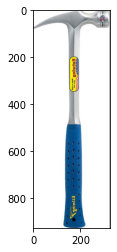

In [48]:
plt.imshow(crop)

In [168]:
cv2.imwrite('crop.png', cv2.cvtColor(crop, cv2.COLOR_RGB2BGR))

True

# Replace Background

In [169]:
new_img_size = img.shape[0]

In [170]:
package_img = Image.new(size=(new_img_size, new_img_size), mode="RGBA", color=(255, 255, 255, 255))

In [171]:
layer = Image.open('crop.png')
# layer = crop

In [172]:
h, w = new_img_size, new_img_size
ww, hh = layer.size[0], layer.size[1]

yoff = (h-hh) //2
xoff = (w-ww)//2

In [173]:
package_img.paste(layer, (xoff,yoff))

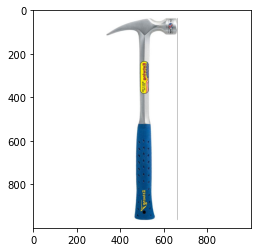

In [174]:
plt.imshow(package_img)